## Homework #3: Analyze ocean-atmosphere coupled climate modes and their impact on global climate

#### Download Global Sea Surface Temperature & Near-Surface Air Temperature (2 m)

- [merge-ts-sst-obsdata-BEST-HadISST-1900-2023.nc](https://drive.google.com/file/d/1hOJwiO6NNaaxh7GCpf6Q9G5By-Tt7PPw/view?usp=drive_link)

#### Download Global Precipitation Over Land & Ocean

- [merge-land-ocean-rainfall-obsdata-GPCC-JRA55-1958-2023.nc](https://drive.google.com/file/d/1_0U77z6tpZWdSF9W5IREtUAnZ7Hj4QXj/view?usp=drive_link)  


#### Instructions After Download

1. Move all files into your **course working directory**.  
2. Work through this notebook independently.  
3. Complete **Questions 1–3** to earn the full **10 points** for Homework #3.

In [1]:
# Import Python libraries for data analysis, plotting, and mapping
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from scipy.stats import linregress

from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

In [2]:
#print working directory; Equivalent to running pwd in a terminal.
! pwd

/Users/xianwu/Documents/python/teaching/Phy_Clim_Sci_Course


### Loading Dataset

- **ts**: Sea surface temperature (SST) over oceans from ERSSTv5 and near-surface air temperature at 2 m (T2m) over land from Berkeley Earth Surface Temperatures (°C)  
- **precip**: Precipitation over land from GPCC and over oceans from NOAA 20th Century Reanalysis (mm/day)

In [3]:
# Define and open a NetCDF dataset using xarray
ds_ts = xr.open_dataset("/Users/xianwu/Documents/python/teaching/Phy_Clim_Sci_Course/data/merge-ts-sst-obsdata-BEST-HadISST-1900-2023.nc", decode_times=False)

ds_rain = xr.open_dataset("/Users/xianwu/Documents/python/teaching/Phy_Clim_Sci_Course/data/merge-land-ocean-rainfall-obsdata-GPCC-JRA55-1958-2023.nc", decode_times=False)

# Assign this time range to the datasets
ds_ts = ds_ts.assign_coords(time=pd.date_range(start="1900-01", end="2023-12", freq="MS"))
ds_rain = ds_rain.assign_coords(time=pd.date_range(start="1958-01", end="2023-12", freq="MS"))

In [4]:
#show information about this dataset
ds_ts

<xarray.Dataset> Size: 329MB
Dimensions:  (time: 1488, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) datetime64[ns] 12kB 1900-01-01 1900-02-01 ... 2023-12-01
Data variables:
    ts       (time, lat, lon) float32 329MB ...

In [5]:
#show information about this dataset
ds_rain

<xarray.Dataset> Size: 175MB
Dimensions:  (time: 792, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) datetime64[ns] 6kB 1958-01-01 1958-02-01 ... 2023-12-01
Data variables:
    rain     (time, lat, lon) float32 175MB ...

In [6]:
# Extract the variable from the datasets
ts = ds_ts['ts'].sel(time=slice("1958-01-01", "2023-12-31"))
rain = ds_rain['rain'].sel(time=slice("1958-01-01", "2023-12-31"))

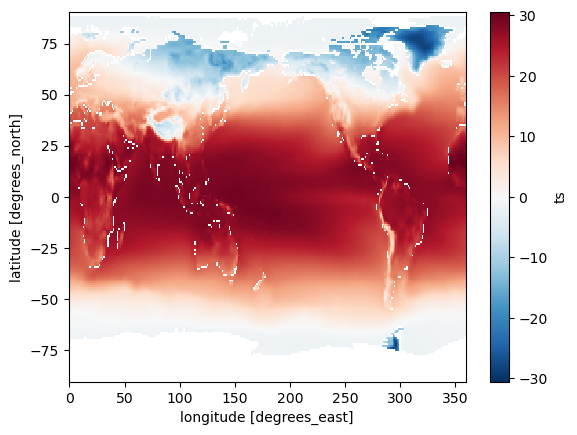

In [7]:
#Quickly check time-mean SST and land T2m
ts.mean('time').plot()

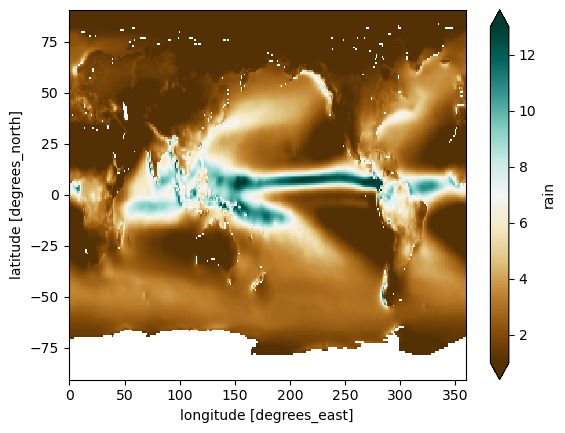

In [8]:
#Quickly check time-mean rainfall
rain.mean('time').plot(vmin=1, vmax=13, cmap='BrBG')

## Preprocessing the data: Calculate monthly anomalies by removing the monthly climatology

- Please go through each cell on your own. We have already learned how to calculate monthly climatology and anomalies in **Homework #1**.
   
- In this step, we also **detrend the data** to remove the long-term warming trend associated with **anthropogenic climate change**, since our focus is on **internal climate variability**.  
- We will focus on the **equatorial region (3°S–3°N)**, connecting to the topics discussed in class:  
  1. Monthly climatology: The SST and rainfall contrast between the **western Pacific warm pool** and **eastern Pacific cold tongue**, the weaker **Atlantic cold tongue**, and the **different mean state** in the **Indian Ocean**.  
  2. Pay attention to the semi-annual cycle of the western Pacific warm pool and the annual cycle of the eastern Pacific cold tongue.  
  3. After removing the seasonal cycle, the **monthly anomalies** along the equator reveal **El Niño** and **La Niña** fluctuations.  

In [9]:
def detrend_linear(da, dim):
    p = da.polyfit(dim=dim, deg=1)
    trend = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - trend

In [10]:
# Computer monthly climatology
ts_monclim = ts.groupby('time.month').mean('time')
rain_monclim = rain.groupby('time.month').mean('time')

# Computer monthly anomaly
ts_anom = ts.groupby('time.month') - ts_monclim
rain_anom = rain.groupby('time.month') - rain_monclim
ts_anom

# Detrend the data
ts_anom_detrended = detrend_linear(ts_anom, dim='time')
rain_anom_detrended = detrend_linear(rain_anom, dim='time')

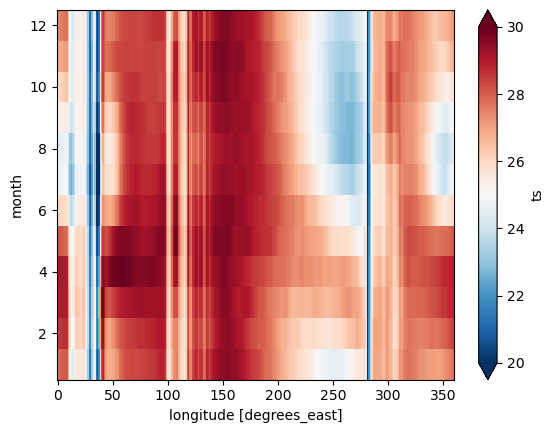

In [11]:
# Plot the climatological monthly mean SST (°C) averaged over the equatorial band (3°S–3°N)
ts_monclim.sel(lat=slice(-3, 3)).mean(dim='lat').plot(vmin=20, vmax=30, cmap='RdBu_r')

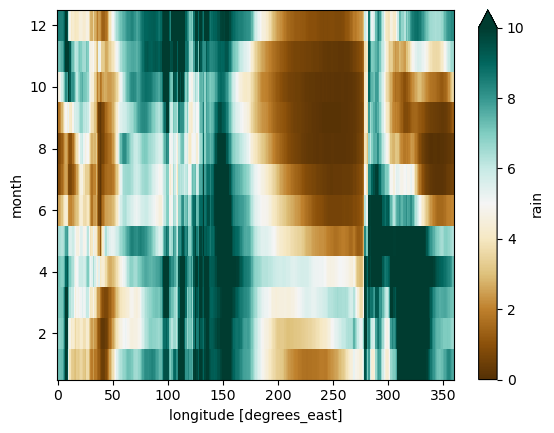

In [12]:
# Plot the climatological monthly mean rainfall (mm/day) averaged over the equatorial band (3°S–3°N)
rain_monclim.sel(lat=slice(-3, 3)).mean(dim='lat').plot(vmin=0, vmax=10, cmap='BrBG')

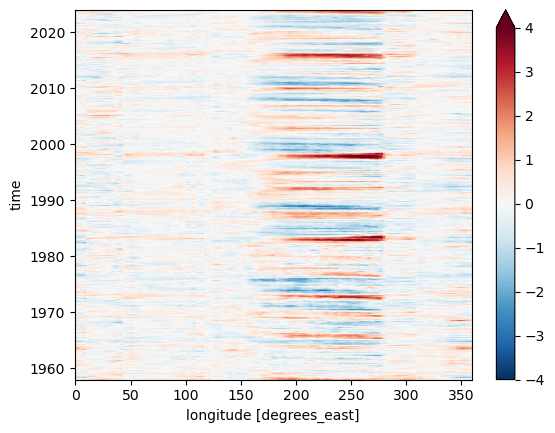

In [13]:
# Plot SST anomalies (°C) averaged over the equatorial band (3°S–3°N) diromg 1958-2023
ts_anom_detrended.sel(lat=slice(-3, 3)).mean(dim='lat').plot(vmin=-4, vmax=4, cmap='RdBu_r')

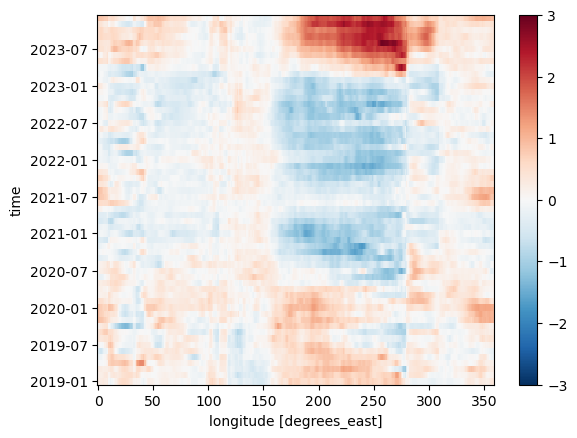

In [14]:
# Zoom into a short time period: Plot equatorial (3°S–3°N) SST anomalies averaged over 2019–2023 (Triple-year La Nina events)
ts_anom_detrended.sel(lat=slice(-3, 3)).mean(dim='lat').sel(time=slice("2019", "2023")).plot(vmin=-3, vmax=3, cmap='RdBu_r')

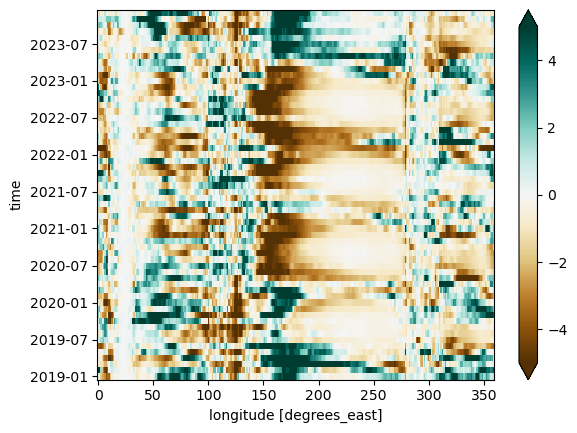

In [15]:
# Zoom into a short time period: Plot equatorial (3°S–3°N) rainfall anomalies averaged over 2019–2023 (Triple-year La Nina events)
rain_anom_detrended.sel(lat=slice(-3, 3)).mean(dim='lat').sel(time=slice("2019", "2023")).plot(vmin=-5, vmax=5, cmap='BrBG')

## <span style="color:blue">Q1: Compute Climate Indices (2 points)</span>

### <span style="color:blue">Below is an example code for calculating the Niño-3.4 SST index. 
### <span style="color:blue">Please calculate the **IOD (DMI)** index (1 pt) and **Atlantic Niño (Atl3)** index (1 pt) on your own, and also briefly interpret your results.</span>

**Common Definitions:**
- **Niño-3.4**: average SST anomalies over 5°S–5°N, 170°W–120°W (`lon: 190–240` in 0–360° notation).  
- **IOD (DMI)**: difference between average SST anomalies in the western box (`10°S–10°N, 50°E–70°E`) and the eastern box (`10°S–0°, 90°E–110°E`).  
- **Atlantic Niño (Atl3)**: average SST anomalies over 3°S–3°N, 20°W–0° (`lon: 340–360` in 0–360° notation).  

In [16]:
def area_weighted_mean(dataarray, lat_name='lat'):
    """
    Compute area-weighted mean of a DataArray.
    Assumes dataarray has a latitude dimension named 'lat' or specified by lat_name.
    """
    weights = np.cos(np.deg2rad(dataarray[lat_name]))
    weights.name = "weights"
    
    weighted_data = dataarray.weighted(weights)
    return weighted_data.mean(dim=[lat_name, 'lon'])

In [17]:
ts_nino34 = area_weighted_mean(ts_anom_detrended.sel(lat=slice(-5, 5), lon=slice(190, 240)))
ts_nino34

<xarray.DataArray (time: 792)> Size: 6kB
array([ 1.63362102e+00,  1.46765789e+00,  1.08325771e+00,  3.65653457e-01,
        4.10898275e-01,  3.47146228e-01,  8.13941532e-02,  2.86261064e-01,
       -2.35633794e-01,  1.43758207e-03,  6.41884248e-02,  3.17926487e-01,
        5.09636137e-01,  5.60721933e-01,  3.44619477e-01,  3.45740714e-01,
        8.40562976e-02, -2.89806740e-01, -2.38496640e-01, -3.69865846e-01,
       -4.56397460e-01,  1.62053042e-01, -1.52644097e-01, -2.50756902e-02,
        1.03530727e-01, -1.80844945e-01,  6.31320236e-03,  7.65596131e-02,
        1.48825671e-01, -1.54153782e-01, -2.04473049e-01,  5.02765085e-02,
        1.19127980e-01, -2.23310585e-02, -3.73426774e-01,  2.69101081e-02,
       -8.70385803e-02,  9.66613448e-02, -1.07225322e-02,  2.12207714e-01,
        1.05050985e-01,  1.55063939e-01, -2.80612756e-01, -2.16806334e-01,
       -4.56835904e-01, -6.85233712e-01, -1.74321589e-01, -2.71728888e-01,
       -1.64987196e-01, -9.76995898e-02, -3.30015243e-01, -2.55069322e-01,
       -3.25751080e-01, -1.69339511e-01, -2.53820264e-01, -7.68964477e-02,
       -4.83457843e-01, -2.81628588e-01, -4.22106689e-01, -4.80037012e-01,
       -2.48916484e-01, -2.02843191e-01,  3.30954666e-02,  1.65159619e-02,
        9.46224881e-02,  1.80531043e-01,  7.91343293e-01,  9.64129045e-01,
        7.39845081e-01,  8.89844567e-01,  7.74169274e-01,  1.08445448e+00,
        8.31020775e-01,  5.97314648e-01, -8.67793697e-02, -4.86994467e-01,
       -6.70922007e-01, -8.62753280e-01, -6.06015546e-01, -7.30416943e-01,
...
        3.39822326e-01,  1.97502288e-01,  1.96068938e-01, -2.24980618e-01,
       -5.64672160e-01, -5.74096020e-01, -9.16190339e-01, -9.22660844e-01,
       -8.76078199e-01, -7.62855169e-01, -7.27007675e-01, -3.63865102e-01,
       -8.48130743e-02,  1.07501472e-01,  2.55526235e-01,  2.53977904e-02,
        3.10625064e-01,  8.23869267e-01,  9.68746840e-01,  9.38455395e-01,
        5.30435382e-01,  6.19849892e-01,  8.37311568e-01,  6.79983611e-01,
        6.48370296e-01,  6.36624540e-01,  3.82475087e-01,  1.64647358e-01,
        1.03727505e-01,  5.19121047e-01,  6.92225126e-01,  4.55119883e-01,
        6.41608105e-01,  4.70809866e-01,  3.76678646e-01,  4.97892796e-01,
       -1.03761172e-01, -2.51837100e-01, -6.81486132e-02, -4.61987624e-01,
       -6.66120398e-01, -1.23691037e+00, -1.09072036e+00, -1.03649986e+00,
       -1.03700175e+00, -9.64060092e-01, -7.10146941e-01, -5.49944096e-01,
       -3.87218653e-01, -7.66505146e-02, -2.15845893e-01, -4.10712857e-01,
       -4.99139425e-01, -8.28253077e-01, -9.46177393e-01, -1.14171160e+00,
       -7.77763249e-01, -7.09388385e-01, -8.25517371e-01, -9.12449851e-01,
       -1.00492099e+00, -7.99538548e-01, -5.78251072e-01, -9.88619681e-01,
       -1.05021828e+00, -1.02741572e+00, -8.15392914e-01, -9.17352691e-01,
       -7.75525078e-01, -6.32412247e-01, -9.92072689e-02,  2.55591857e-01,
        5.22412498e-01,  9.49214978e-01,  1.21401821e+00,  1.57392154e+00,
        1.69826066e+00,  1.58233652e+00,  1.99126244e+00,  1.78340563e+00])
Coordinates:
  * time     (time) datetime64[ns] 6kB 1958-01-01 1958-02-01 ... 2023-12-01
    month    (time) int64 6kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

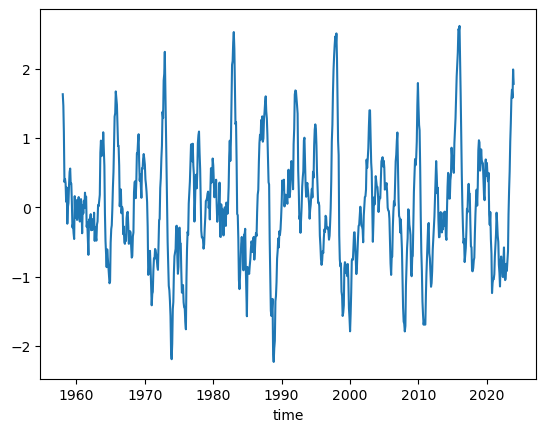

In [18]:
ts_nino34.plot()

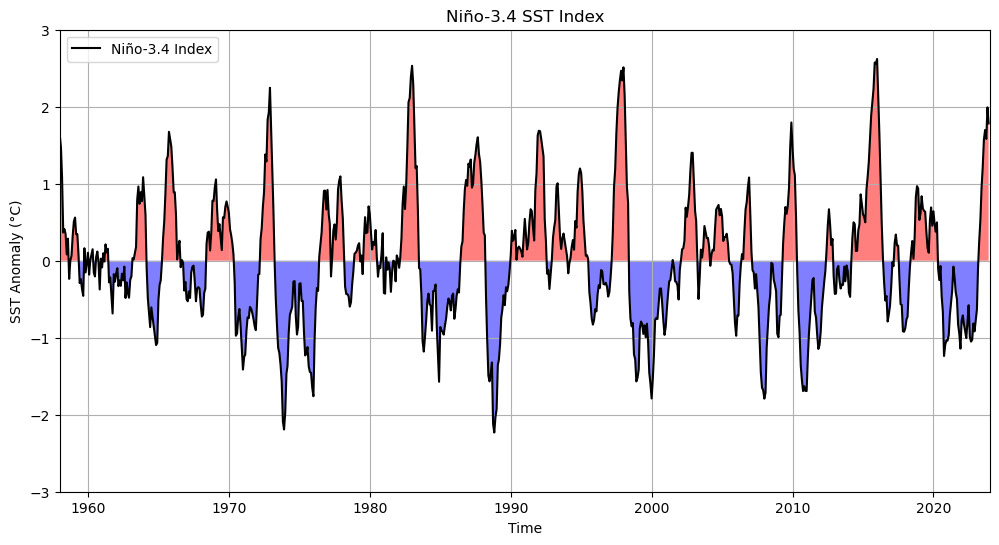

In [19]:
#make the timeseries plot nicer
# Plot the Niño-3.4 index
plt.figure(figsize=(12, 6))
plt.plot(ts_nino34['time'], ts_nino34, label='Niño-3.4 Index', color='black')
plt.fill_between(ts_nino34['time'], ts_nino34, where=(ts_nino34 > 0), facecolor='red', alpha=0.5)
plt.fill_between(ts_nino34['time'], ts_nino34, where=(ts_nino34 < 0), facecolor='blue', alpha=0.5)

plt.xlabel('Time')
plt.ylabel('SST Anomaly (°C)')
plt.title('Niño-3.4 SST Index')
plt.xlim(pd.Timestamp('1958-01-01'), pd.Timestamp('2023-12-31'))  # Adjust this as necessary for the present date
plt.ylim(-3, 3)  # Set y-axis range
plt.legend()
plt.grid()
plt.show()

In [20]:
#DMI


In [21]:
#ATL


## <span style="color:blue">Q2: Compute Global SST, Land T2m, and Rainfall Regressed onto Climate Indices (4 points)</span>
### <span style="color:blue">Purpose:</span>
#### Regression analysis helps us quantify the linear relationship between a climate variable (such as SST, surface air temperature, or rainfall) and a chosen climate index (e.g., Niño-3.4, IOD, or Atlantic Niño).
#### By regressing global fields onto these indices, we can identify regions that vary coherently with each mode of climate variability, revealing their global teleconnection patterns.

### Below is an example code that calculates the global regression of SST onto the Niño-3.4 SST index.
### <span style="color:blue"> Please use a similar approach to calculate and plot the global regression onto: IOD (DMI) index — 2 points & Atlantic Niño (Atl3) index — 2 points, and also briefly interpret your results. </span>



In [22]:
def regress_field_on_index_anom(field_da, index_series):
    """
    Regress a 3D field (time, lat, lon) on a 1D index (time) using pre-computed anomalies.
    Returns the slope at each gridpoint as a DataArray with proper lat/lon coordinates.
    """
    # Ensure the index is an xarray DataArray aligned to time
    idx = xr.DataArray(index_series.values, coords={'time': field_da['time']}, dims='time')
    
    # Compute slope = cov(X,Y)/var(X)
    cov = (idx * field_da).sum(dim='time') / (len(idx) - 1)
    varX = (idx ** 2).sum(dim='time') / (len(idx) - 1)
    slope = cov / varX
    
    # Make sure slope has lat/lon coordinates
    slope = xr.DataArray(
        slope.values,
        coords={'lat': field_da.lat, 'lon': field_da.lon},
        dims=['lat', 'lon']
    )
    
    return slope

In [23]:
# Example: regression of rain onto Nino3.4
tsreg_on_ts_nino34= regress_field_on_index_anom(ts_anom_detrended, ts_nino34)
rainreg_on_ts_nino34= regress_field_on_index_anom(rain_anom_detrended, ts_nino34)

In [24]:
rainreg_on_ts_nino34

<xarray.DataArray (lat: 192, lon: 288)> Size: 442kB
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.02777562, -0.02753106, -0.02739602, ..., -0.02852744,
        -0.02775802, -0.02784844],
       [-0.02352745, -0.02334564, -0.02323941, ..., -0.02413386,
        -0.02352745, -0.02352745],
       [-0.01373632, -0.01373632, -0.01373632, ..., -0.01373632,
        -0.01373632, -0.01373632]], shape=(192, 288))
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

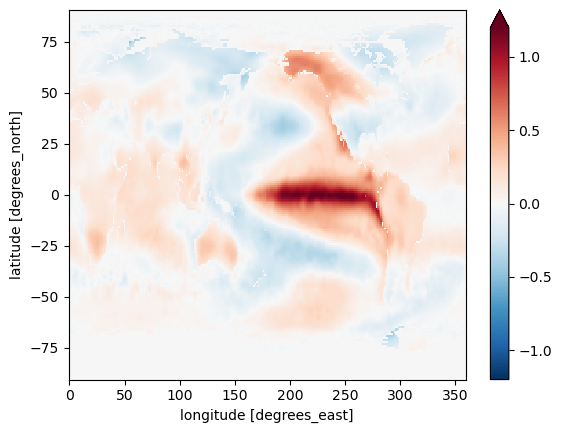

In [25]:
tsreg_on_ts_nino34.plot(vmin=-1.2, vmax=1.2, cmap='RdBu_r')

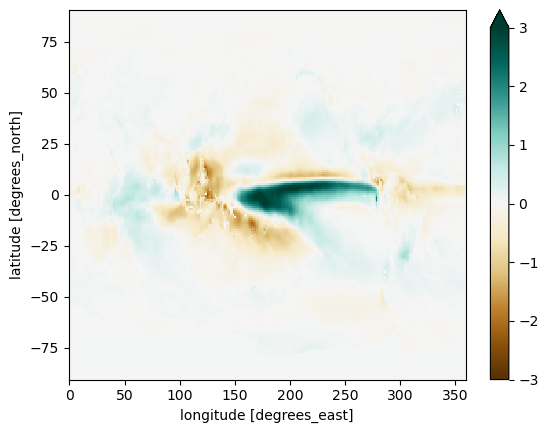

In [26]:
rainreg_on_ts_nino34.plot(vmin=-3, vmax=3, cmap='BrBG')

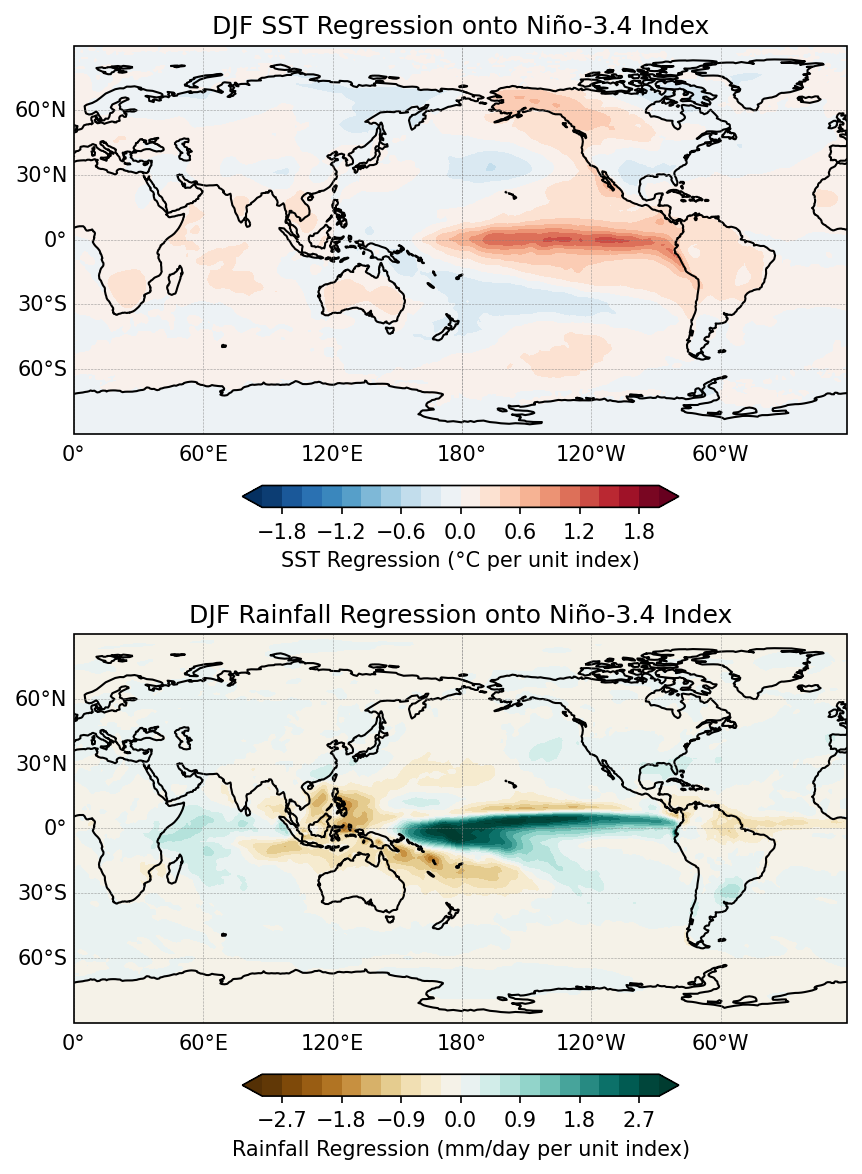

In [27]:
fig, axes = plt.subplots(
    2, 1, figsize=(10, 8),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)},
    dpi=150
)

# --- SST Regression ---
cf1 = axes[0].contourf(
    tsreg_on_ts_nino34.lon, tsreg_on_ts_nino34.lat, tsreg_on_ts_nino34,
    levels=np.linspace(-2., 2., 21),
    cmap='RdBu_r',
    extend='both',
    transform=ccrs.PlateCarree()
)
axes[0].coastlines()
gl = axes[0].gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
axes[0].set_title('DJF SST Regression onto Niño-3.4 Index', fontsize=12)
plt.colorbar(cf1, ax=axes[0], orientation='horizontal', pad=0.1, shrink=0.3, label='SST Regression (°C per unit index)')

# --- Rainfall Regression ---
cf2 = axes[1].contourf(
    rainreg_on_ts_nino34.lon, rainreg_on_ts_nino34.lat, rainreg_on_ts_nino34,
    levels=np.linspace(-3, 3, 21),  # adjust color range for rainfall
    cmap='BrBG',
    extend='both',
    transform=ccrs.PlateCarree()
)
axes[1].coastlines()
gl = axes[1].gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
axes[1].set_title('DJF Rainfall Regression onto Niño-3.4 Index', fontsize=12)
plt.colorbar(cf2, ax=axes[1], orientation='horizontal', pad=0.1, shrink=0.3, label='Rainfall Regression (mm/day per unit index)')

plt.tight_layout()
plt.show()

## <span style="color:blue">Q3: Analyze the Relationship Between Regional Temperature/Rainfall and Climate Indices (4 points)</span>

### - Select two region’s (2 points each) **surface temperature (TS)** or **rainfall**, and investigate how they **correlate with major climate variability indices** such as **ENSO (Niño-3.4)**, **IOD (DMI)**, or **Atlantic Niño (Atl3)**.  

### - Use the **regression maps from Q2** to identify a region where the **regression values are large**, indicating a strong climate influence.  

### **Example:** Calculate **Southern U.S. rainfall** during **December** and the **Niño-3.4 index** in DJF, then plot their **time series** and calculate the **correlation coefficient**.  

### **Note:** The **Indian Ocean Dipole (IOD)** typically shows its strongest influence during **September–November (SON)**, while the **Atlantic Niño** tends to be most important during **June–August (JJA)**.


Rainfall regression slope: 0.36 mm/day per unit index, correlation r: 0.54, p-value: 0.000


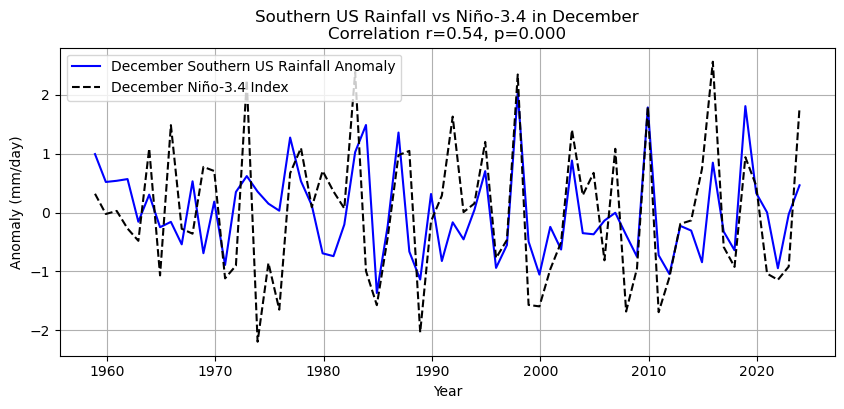

In [28]:
from scipy.stats import linregress
import matplotlib.pyplot as plt
import xarray as xr

# --- Define the region (Southern US) ---
lat_slice = slice(25, 37)  # ~25°N to 37°N
lon_slice = slice(260, 295)  # ~100°W to 65°W in 0-360 longitude

# --- Extract regional mean December rainfall directly ---
rain_southUS_Dec = rain_anom_detrended.sel(time=rain_anom_detrended['time'].dt.month == 12,
                                       lat=lat_slice, lon=lon_slice).mean(dim=['lat', 'lon'])

# --- Select Niño-3.4 index for December directly ---
nino34_Dec = ts_nino34.sel(time=ts_nino34['time'].dt.month == 12)

# --- Regression / Correlation for rainfall ---
slope_rain, intercept_rain, r_value_rain, p_value_rain, std_err_rain = linregress(
    nino34_Dec.values, rain_southUS_Dec.values
)

print(f"Rainfall regression slope: {slope_rain:.2f} mm/day per unit index, "
      f"correlation r: {r_value_rain:.2f}, p-value: {p_value_rain:.3f}")

# --- Plot rainfall time series vs Niño-3.4 index ---
plt.figure(figsize=(10,4))
plt.plot(rain_southUS_Dec['time'], rain_southUS_Dec, label='December Southern US Rainfall Anomaly', color='blue')
plt.plot(nino34_Dec['time'], nino34_Dec, label='December Niño-3.4 Index', color='black', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Anomaly (mm/day)')
plt.title(f'Southern US Rainfall vs Niño-3.4 in December\nCorrelation r={r_value_rain:.2f}, p={p_value_rain:.3f}')
plt.legend()
plt.grid()
plt.show()


In [29]:
rain_southUS_Dec

<xarray.DataArray (time: 66)> Size: 528B
array([ 0.99137889,  0.51820287,  0.53808206,  0.56731393, -0.15636077,
        0.30319456, -0.24896751, -0.15868455, -0.53981625,  0.52931594,
       -0.69044323,  0.18506539, -0.88931477,  0.34808924,  0.61811068,
        0.35441175,  0.15035683,  0.03103199,  1.27175987,  0.53188823,
        0.12166395, -0.6925211 , -0.74018656, -0.20382865,  1.02385678,
        1.48483872, -1.36530971, -0.2300361 ,  1.35668762, -0.66289344,
       -1.1363157 ,  0.31442942, -0.82280987, -0.16624355, -0.45547594,
        0.04331299,  0.70228209, -0.93943071, -0.55208074,  2.0395244 ,
       -0.49262867, -1.05295618, -0.24378825, -0.62778775,  0.88150632,
       -0.35033675, -0.36927155, -0.13688628, -0.00417451, -0.38182241,
       -0.74947004,  1.78280363, -0.72481352, -1.045027  , -0.22722229,
       -0.3063213 , -0.84324301,  0.84582233, -0.32377001, -0.64023189,
        1.80491149,  0.33016756,  0.00251199, -0.94490154, -0.03038807,
        0.46174801])
Coordinates:
  * time     (time) datetime64[ns] 528B 1958-12-01 1959-12-01 ... 2023-12-01
    month    (time) int64 528B 12 12 12 12 12 12 12 12 ... 12 12 12 12 12 12 12